# Выпускной проект: Промышленность. Предсказание температуры стали.

## Описание задачи
Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали. 

Заказчик хочет увидеть качество выполнения проекта при одних и тех же условиях, т.е. **RANDOM_STATE** = 150523. 

Необходимо предсказать последний замер температуры партии используя метрику MAE. 

**MAE должна быть не больше 6.8.**

## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.


## План проекта:
**1. Провести исследовательский анализ и начальную предобработку данных:**
- привести типы данных к корректному виду;
- рассмотреть и заменить/удалить пропущенные значения;
- рассмотреть аномальные значения (выбросы), при невозможности заменить их - удалить;
- проверить таблицы на дублирующие значения;
- рассмотреть распределение данных.

*После проведения исследовательского анализа, план будет дополнен*

In [51]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import *

from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor


In [52]:
try:
    data_arc = pd.read_csv('/datasets/data_arc_new.csv') # данные об электродах
    data_bulk = pd.read_csv('/datasets/data_bulk_new.csv') # данные о подаче сыпучих материалов (объём)
    data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv') # данные о подаче сыпучих материалов (время)
    data_gas = pd.read_csv('/datasets/data_gas_new.csv') # данные о продувке сплава газом
    data_temp = pd.read_csv('/datasets/data_temp_new.csv') # результаты измерения температуры
    data_wire = pd.read_csv('/datasets/data_wire_new.csv') # данные о проволочных материалах (объём)
    data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv') # данные о проволочных материалах (время)
except:
    data_arc = pd.read_csv('C:/Users/ven89/OneDrive/Desktop/Кожемякина/Industry_ML/data_arc_new.csv')
    data_bulk = pd.read_csv('C:/Users/ven89/OneDrive/Desktop/Кожемякина/Industry_ML/data_bulk_new.csv')
    data_bulk_time = pd.read_csv('C:/Users/ven89/OneDrive/Desktop/Кожемякина/Industry_ML/data_bulk_time_new.csv')
    data_gas = pd.read_csv('C:/Users/ven89/OneDrive/Desktop/Кожемякина/Industry_ML/data_gas_new.csv')
    data_temp = pd.read_csv('C:/Users/ven89/OneDrive/Desktop/Кожемякина/Industry_ML/data_temp_new.csv')
    data_wire = pd.read_csv('C:/Users/ven89/OneDrive/Desktop/Кожемякина/Industry_ML/data_wire_new.csv')
    data_wire_time = pd.read_csv('C:/Users/ven89/OneDrive/Desktop/Кожемякина/Industry_ML/data_wire_time_new.csv')

In [53]:
# названия таблиц
data_arc.name = 'Данные об электродах'
data_bulk.name = 'Данные о подаче сыпучих материалов (объём)'
data_bulk_time.name = 'Данные о подаче сыпучих материалов (время)'
data_gas.name = 'Данные о продувке сплава газом'
data_temp.name = 'Pезультаты измерения температуры'
data_wire.name = 'Данные о проволочных материалах (объём)'
data_wire_time.name = 'Данные о проволочных материалах (время)'

In [54]:
# функция для вывода информации 
def begin(data):
    print('\033[1m' + '\n    Состав таблицы:' + '\033[0m', '\033[1m' + data.name + '\033[0m', '\n')
    display(data.head(7))
    print('\033[1m' + '\n    Общая информация:' + '\033[0m', '\033[1m' + data.name + '\033[0m', '\n')
    print(data.info())
    print('\033[1m' + '\n    Описательная статистика:' + '\033[0m', '\033[1m' + data.name + '\033[0m', '\n')
    display(data.describe())
    print('\033[1m' + '\nКоличество пропущенных значений' + '\033[0m', data.isna().sum().sum())
    print('\033[1m' + 'Количество дубликатов:' + '\033[0m', data.duplicated().sum())
    print('\033[1m' + 'Количество уникальных партий -'+ '\033[0m', data['key'].nunique())

In [55]:
# информация об электродах
begin(data_arc)


    Состав таблицы: Данные об электродах 



,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527



    Общая информация: Данные об электродах 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None

    Описательная статистика: Данные об электродах 



,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284



Количество пропущенных значений 0
Количество дубликатов: 0
Количество уникальных партий - 3214


В таблице данные об электродах содержится 14 876 строк и 5 столбцов. Пропущенных и дублирующих значений нет.  Количество уникальных партий - 3214. Необходимо привести Даты к виду datetime для дальнейшего анализа. Обратим внимание, что реактивная мощность имеет отрицательное значение, такого быть не может. Рассмотрим это подробнее.

In [56]:
data_arc[data_arc['Реактивная мощность']<0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [57]:
# удалим это значение
data_arc = data_arc[data_arc['Реактивная мощность']>0]

In [58]:
# проверка
data_arc.shape

(14875, 5)

In [59]:
# приведем даты к корректному типу данных
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format = '%Y-%m-%d %H:%M:%S')
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format = '%Y-%m-%d %H:%M:%S')

In [60]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14875 non-null  int64         
 1   Начало нагрева дугой  14875 non-null  datetime64[ns]
 2   Конец нагрева дугой   14875 non-null  datetime64[ns]
 3   Активная мощность     14875 non-null  float64       
 4   Реактивная мощность   14875 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 697.3 KB


In [61]:
# посмотрим как часто происходил нагрев по партиям
data_arc['key'].value_counts()

2108    16
1689    15
1513    15
2567    14
46      13
        ..
247      1
2582     1
943      1
248      1
530      1
Name: key, Length: 3214, dtype: int64

Чаще всего нагревались партии 2108, 1513 и 1689, скорее всего, это связано с тем, что не был достигнут целевой химический состав и оптимальная температура плавки из-за добавления определенных примесей.

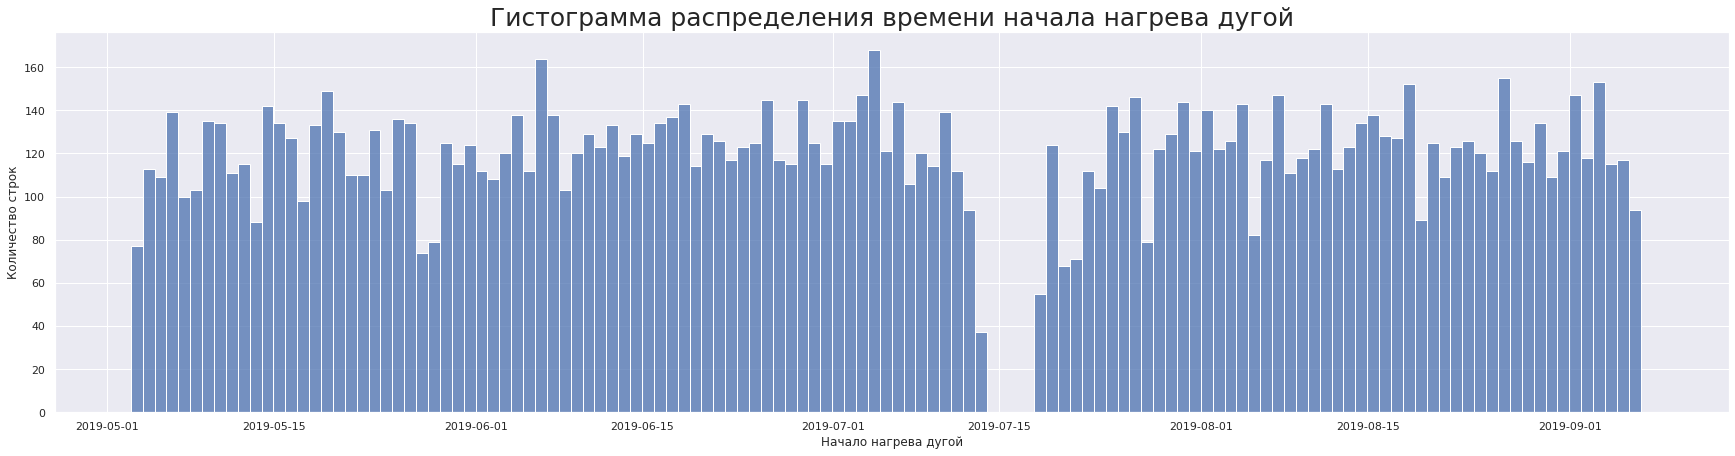

In [62]:
# построим гистаграмму распределения для признака 'Начало нагрева дугой'
sns.set(rc={"figure.figsize": (30, 7)})
ahs = sns.histplot(data=data_arc, x='Начало нагрева дугой', discrete=True)
ahs.set_ylabel('Количество строк')
ahs.set_title('Гистограмма распределения времени начала нагрева дугой', fontsize=25);

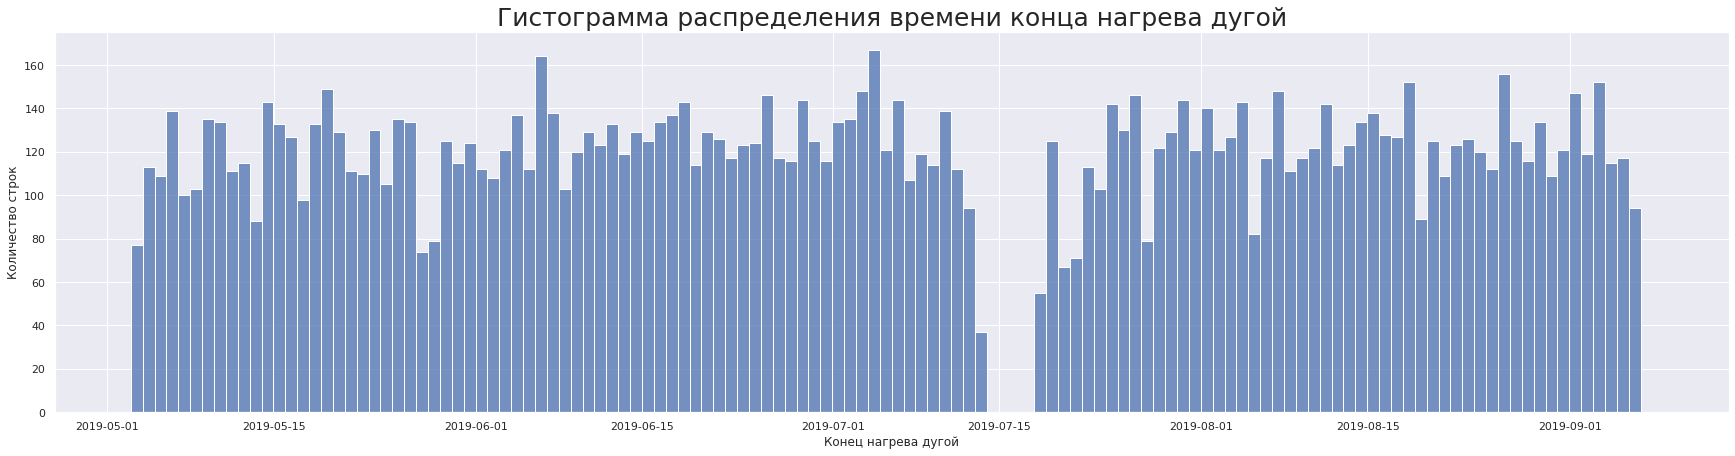

In [63]:
# построим гистаграмму распределения для признака 'Конец нагрева дугой'
sns.set(rc={"figure.figsize": (30, 7)})
ahs = sns.histplot(data=data_arc, x='Конец нагрева дугой', discrete=True)
ahs.set_ylabel('Количество строк')
ahs.set_title('Гистограмма распределения времени конца нагрева дугой', fontsize=25);

In [64]:
# начало исследуемого периоды
print(data_arc['Начало нагрева дугой'].min())
print(data_arc['Конец нагрева дугой'].min())

2019-05-03 11:02:14
2019-05-03 11:06:02


In [65]:
# конец исследуемого периоды
print(data_arc['Начало нагрева дугой'].max())
print(data_arc['Конец нагрева дугой'].max())

2019-09-06 17:24:54
2019-09-06 17:26:15


In [66]:
# дни работы в июле
data_arc['Начало нагрева дугой'].dt.day[data_arc['Начало нагрева дугой'].dt.month==7].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [67]:
# дни работы в июле
data_arc['Конец нагрева дугой'].dt.day[data_arc['Начало нагрева дугой'].dt.month==7].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

Нам предоставлены данные с 3 мая 2019 года по 6 сентября 2019 года. По гистограммам наблюдается резкий спад и отсутсвие информации 14-17 июля. Скорее всего это связано с аварией или простоем производства.

Text(0.5, 0.98, 'Распределение реактивной и активной мощностей')

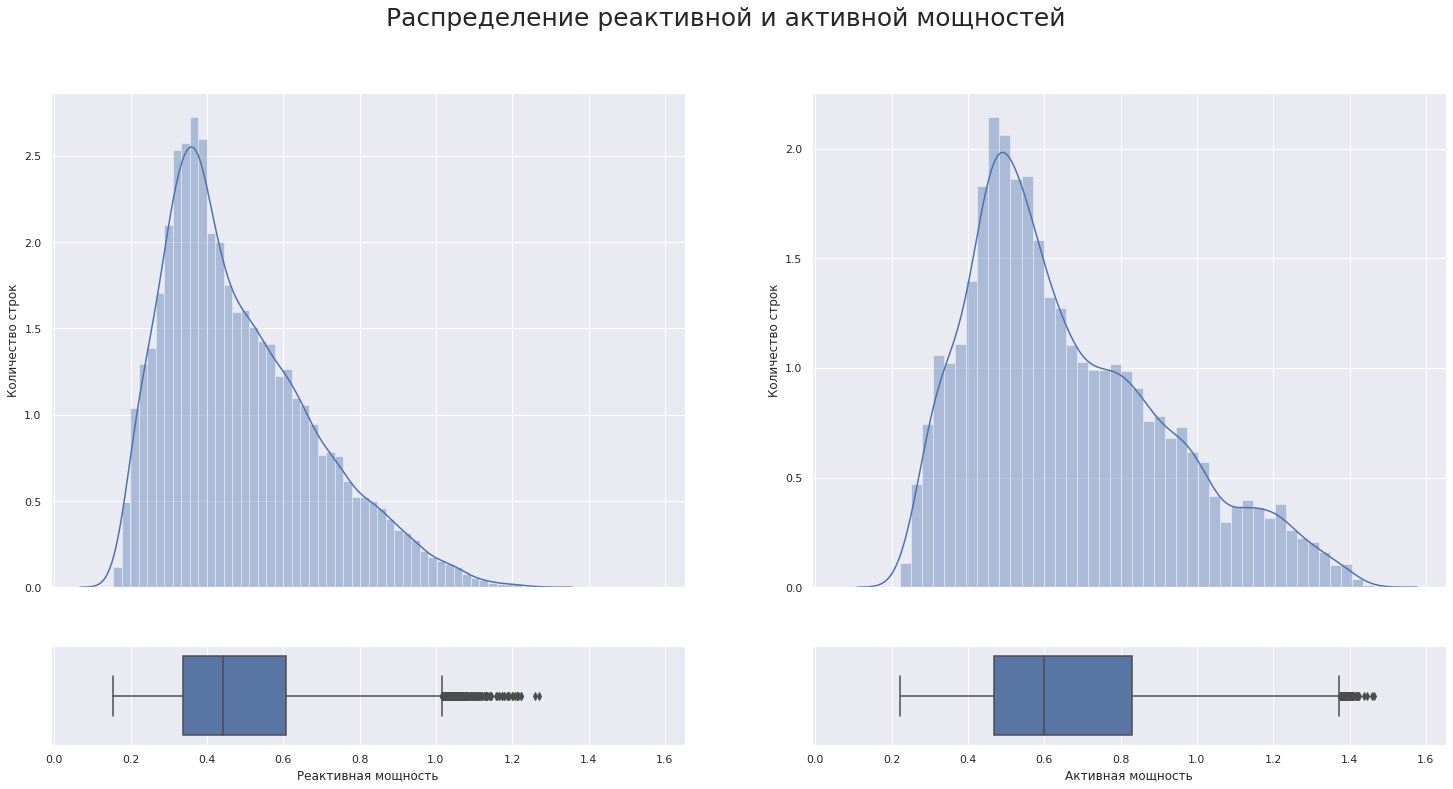

In [68]:
# построим гистограммы распределения по мощностям
f, [[ax_hist, ax_hist_2], [ax_box, ax_box_2]] = plt.subplots(2, 2, sharex=True, figsize=(25,12), 
                                                             gridspec_kw=dict(height_ratios=[10,2]))


sns.boxplot(data_arc["Реактивная мощность"], ax=ax_box)
sns.distplot(data_arc["Реактивная мощность"], ax=ax_hist)

sns.boxplot(data_arc["Активная мощность"], ax=ax_box_2)
sns.distplot(data_arc["Активная мощность"], ax=ax_hist_2)
 

ax_hist.set(xlabel='Реактивная мощность', ylabel='Количество строк')
ax_hist_2.set(xlabel='Активная мощность', ylabel='Количество строк')
f.suptitle('Распределение реактивной и активной мощностей', fontsize=25)


Распределение активной и реактивной мощностей похожи между собой. Распределение похоже на нормальное со смещением влево. Посмотрим корреляцию между ними.

In [69]:
data_arc[['Реактивная мощность', 'Активная мощность']].corr()

,Реактивная мощность,Активная мощность
Реактивная мощность,1.000000,0.966373
Активная мощность,0.966373,1.000000


Между мощностями наблюдается мультиколлениарность, что в последствии может повлиять на наш прогноз. Погуглив как соотносится активная и реактивная мощность, предлагаю по этим данным найти полную мощность и использовать ее в дальнейшем.
Формула полной мощности (S):

$S = \sqrt{РеактивнаяMощность^2+АктивнаяMощность^2}$

In [70]:
data_arc['Полная мощность'] = np.sqrt((data_arc['Реактивная мощность']**2)+(data_arc['Активная мощность']**2))

In [71]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934


## Данные о подаче сыпучих материалов (объём)

In [72]:
begin(data_bulk)


    Состав таблицы: Данные о подаче сыпучих материалов (объём) 



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0



    Общая информация: Данные о подаче сыпучих материалов (объём) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None

    Описательная статистика: Данные о подаче сыпучих материалов (объём) 



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000



Количество пропущенных значений 35776
Количество дубликатов: 0
Количество уникальных партий - 3129


В данной таблице представлена информация о сыпучих материалов. Всего сток - 3129, столбцов - 16 (один столбец с номером партии и остальные 15 - это примеси). Пропущенные значения скорее всего связаны с тем, что не было необходимости добавлять примеси в сплав. Посмотрим на гистограмму распределения и заменим пропущенные значения на 0 (т.е. примеси не добавлялись)

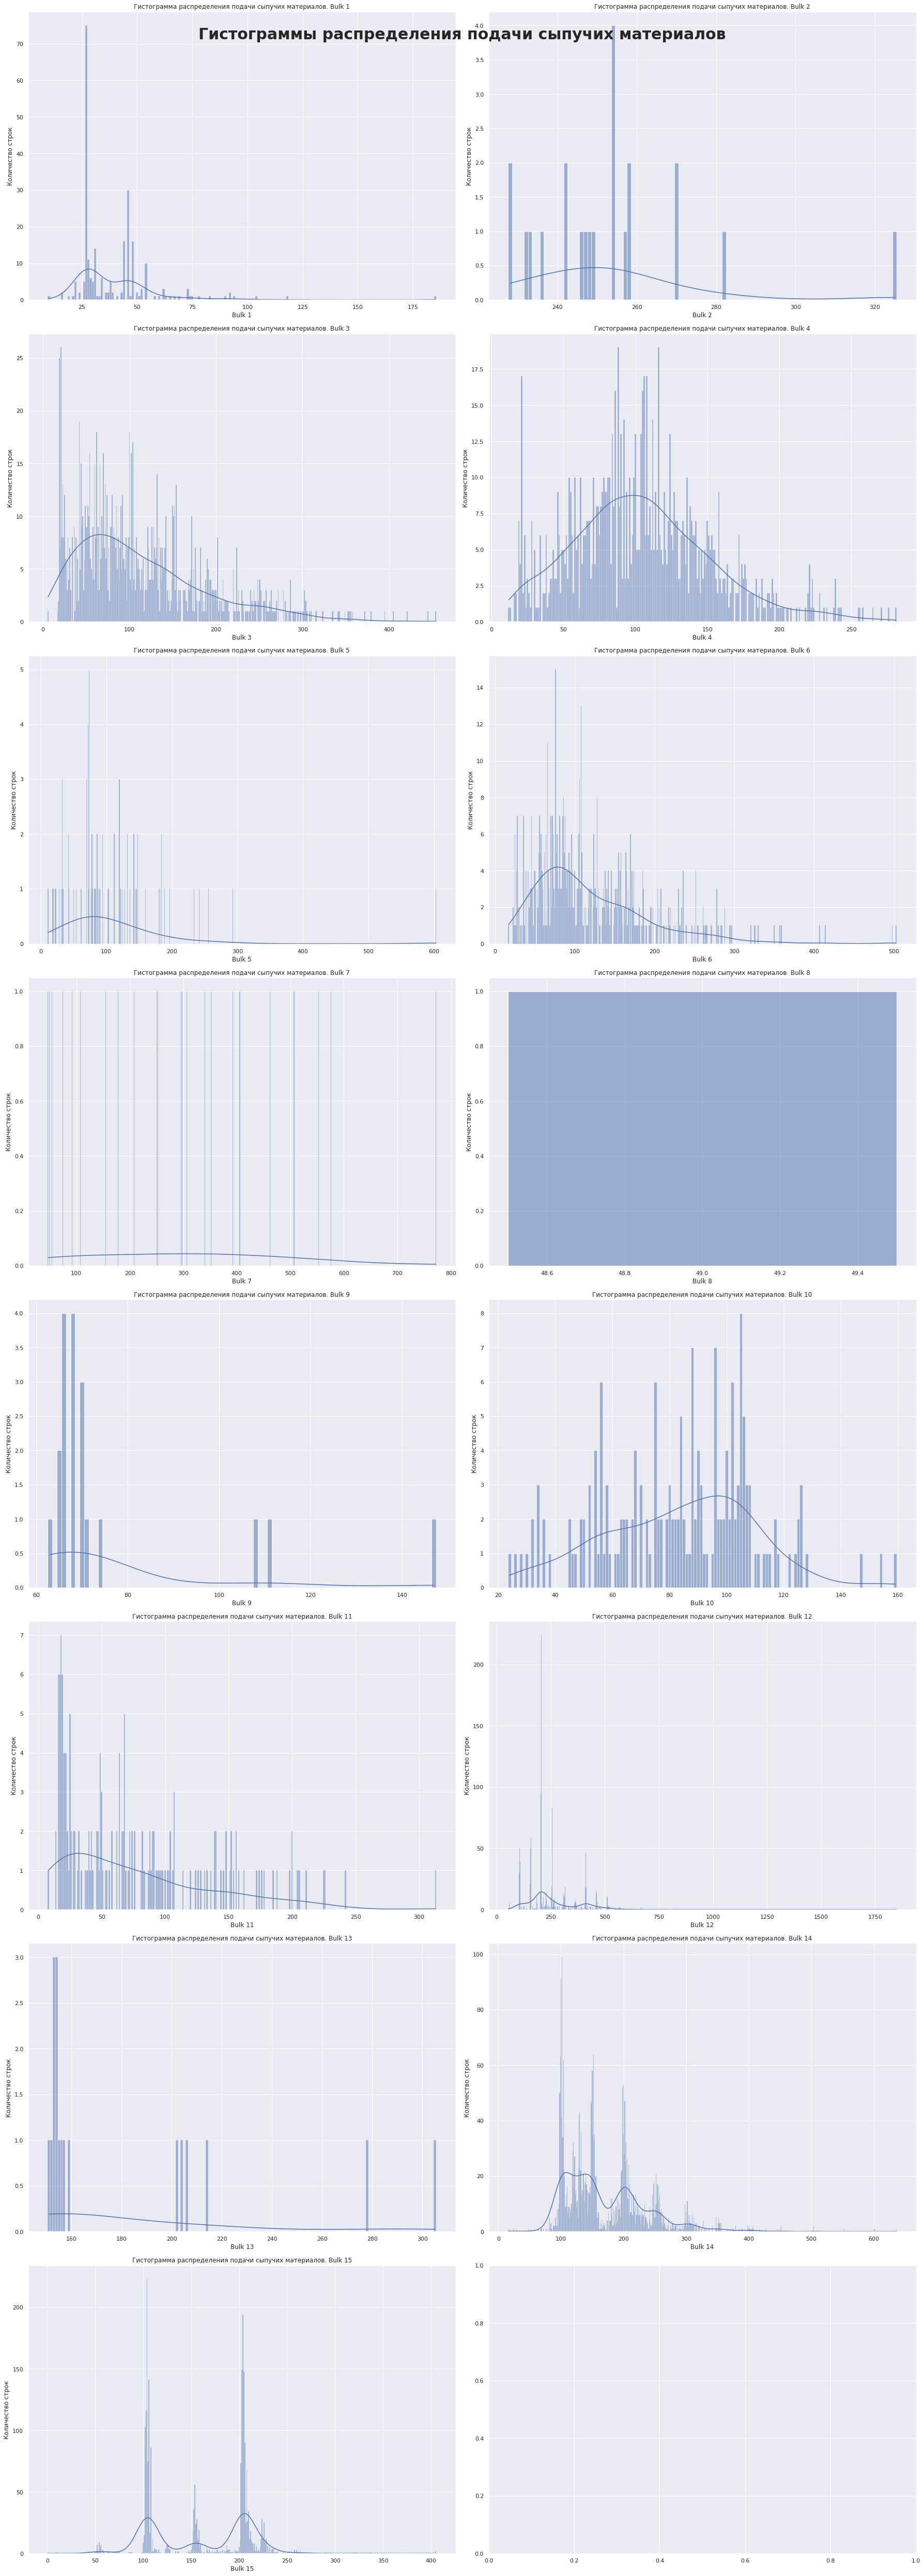

In [73]:
# гистограммы сыпучих материалов
fig, ax = plt.subplots(8, 2, figsize = (25,70))
fig.suptitle('Гистограммы распределения подачи сыпучих материалов', fontsize = 30, fontweight='bold')
bulks = data_bulk.columns.to_list()[1:]
ax = ax.flatten()


for i, bulk in enumerate(bulks):
    bulk_hist=sns.histplot(data=data_bulk, x=bulk, kde=True, ax=ax[i], discrete=True)
    bulk_hist.set_ylabel('Количество строк')
    bulk_hist.set_title('Гистограмма распределения подачи сыпучих материалов. ' + bulk)
  
    plt.tight_layout()
    
 

По гистограммам видно, что сыпучие материалы добавляются в разных объемах. Чаще всего добавляют Bulk 12. Bulk 14, Bulk 15 и только 1 раз добавили Bulk 8. То есть разные сыпучие материалы имеют разный состави и по-разному действуют на металл, а Bulk 8 либо крайне редко использующаяся легирующая добавка, либо крайне дорогая, либо и то, и то.

In [74]:
# замена пропущенных значений
data_bulk = data_bulk.fillna(0)

In [75]:
# проверка
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


## Данные о подаче сыпучих материалов (время)

In [76]:
begin(data_bulk_time)


    Состав таблицы: Данные о подаче сыпучих материалов (время) 



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16



    Общая информация: Данные о подаче сыпучих материалов (время) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None

    Описательная статистика: Данные о подаче сыпучих материалов (время) 



,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000



Количество пропущенных значений 35776
Количество дубликатов: 0
Количество уникальных партий - 3129


Построим гистограмму распределения, заменим тип данных на корректный.

In [77]:
# заменим тип данных
data_bulk_time[bulks] = data_bulk_time[bulks].astype('datetime64')

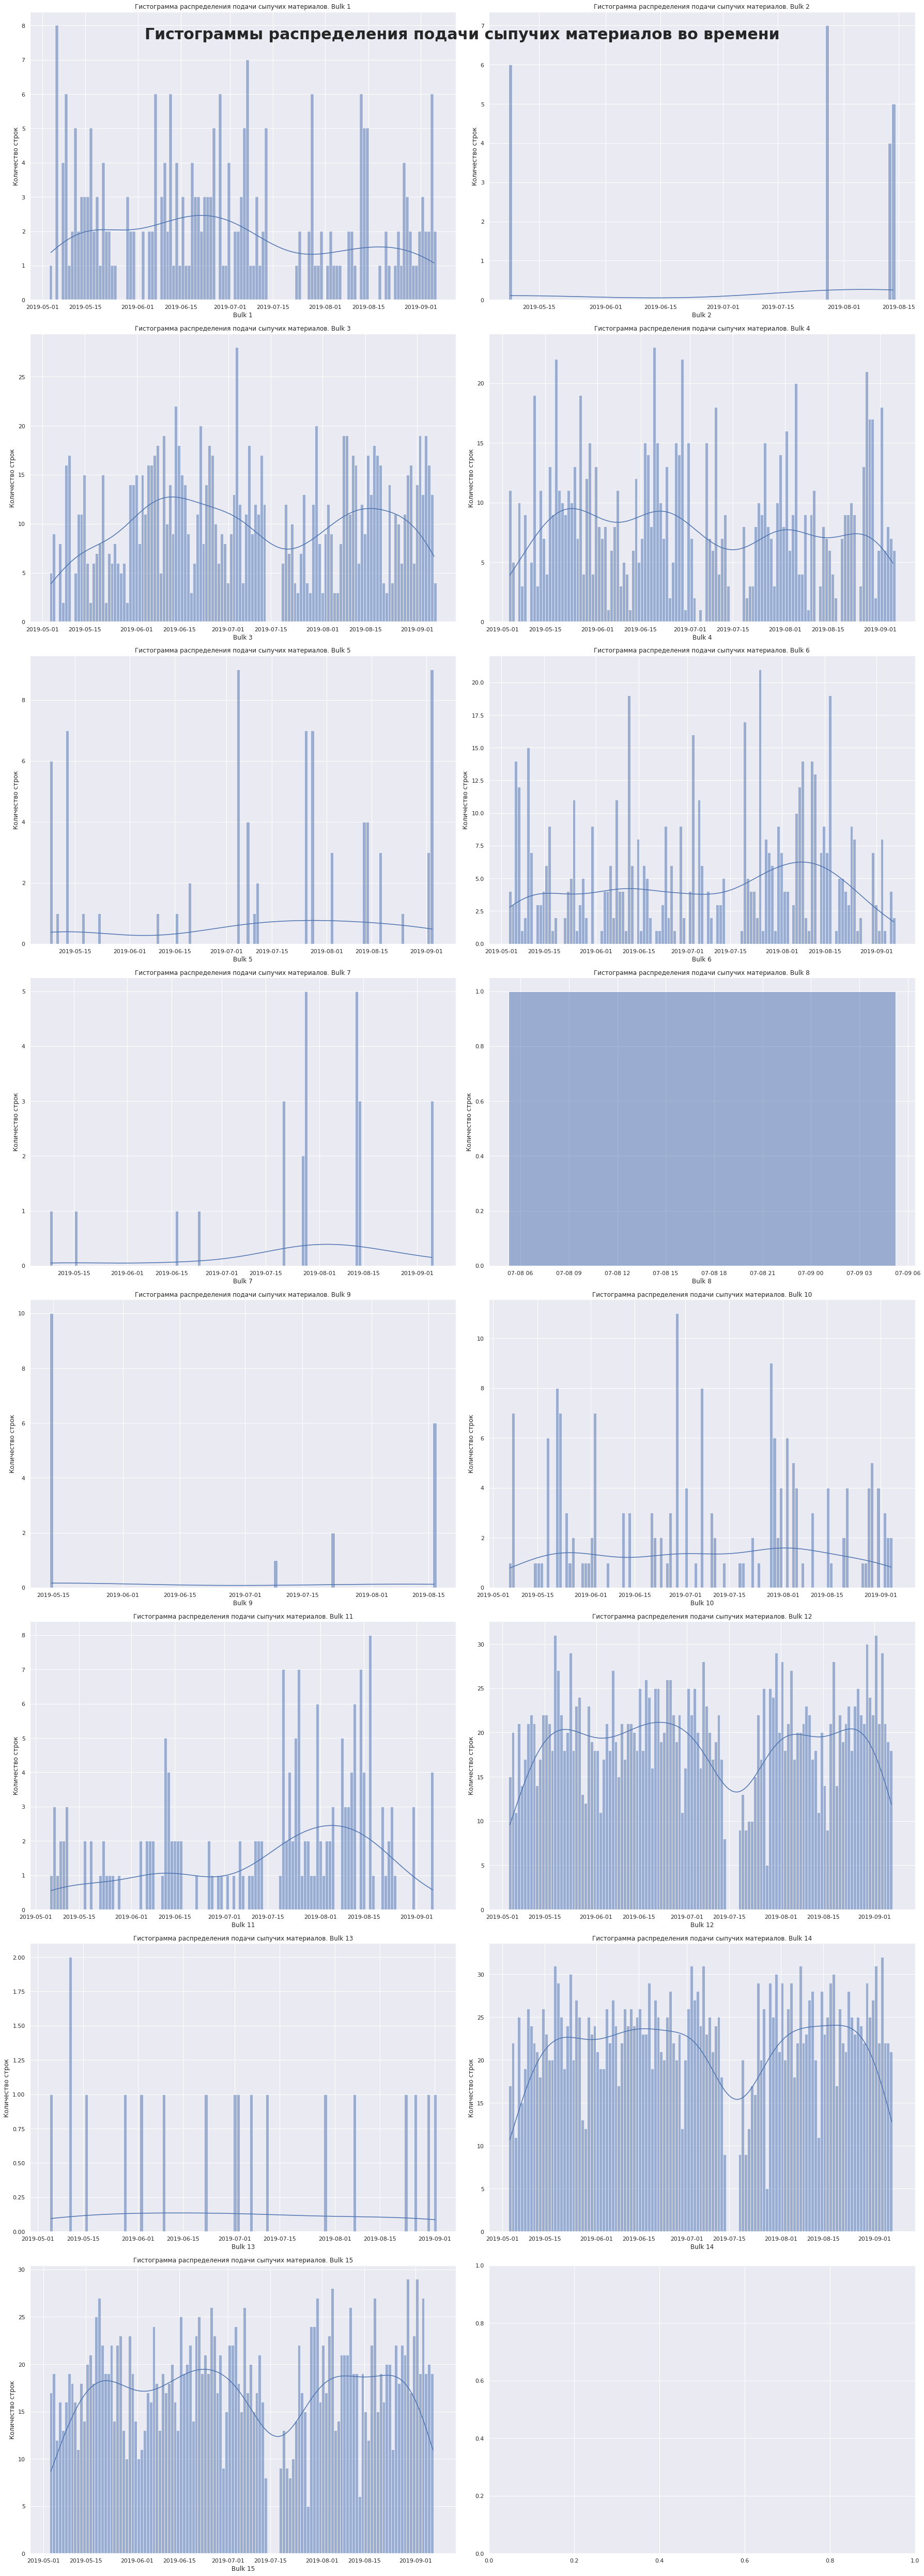

In [78]:
# гистограммы сыпучих материалов
fig, ax = plt.subplots(8, 2, figsize = (25,70))
fig.suptitle('Гистограммы распределения подачи сыпучих материалов во времени', fontsize = 30, fontweight='bold')
bulks = data_bulk.columns.to_list()[1:]
ax = ax.flatten()


for i, bulk in enumerate(bulks):
    bulk_hist=sns.histplot(data=data_bulk_time, x=bulk, kde=True, ax=ax[i], discrete=True)
    bulk_hist.set_ylabel('Количество строк')
    bulk_hist.set_title('Гистограмма распределения подачи сыпучих материалов. ' + bulk)
  
    plt.tight_layout()

По гистограммам видно, что пропуски в июле присутствуют, аналогичный пропуску в data_arc, что логично. Данные гистограммы полностью соответствуют гистограммам из датафрема data_bulk

## Данные о продувке сплава газом

In [79]:
begin(data_gas)


    Состав таблицы: Данные о продувке сплава газом 



,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267



    Общая информация: Данные о продувке сплава газом 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None

    Описательная статистика: Данные о продувке сплава газом 



,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040



Количество пропущенных значений 0
Количество дубликатов: 0
Количество уникальных партий - 3239


В таблице по информации о продувке сплава газом всего два столбца. Пропущенных и дублирующих значений нет. Количество уникальных значений партий отличается от предыдущих датафреймов. здесь их 3239. Посмотрим на распределение данных

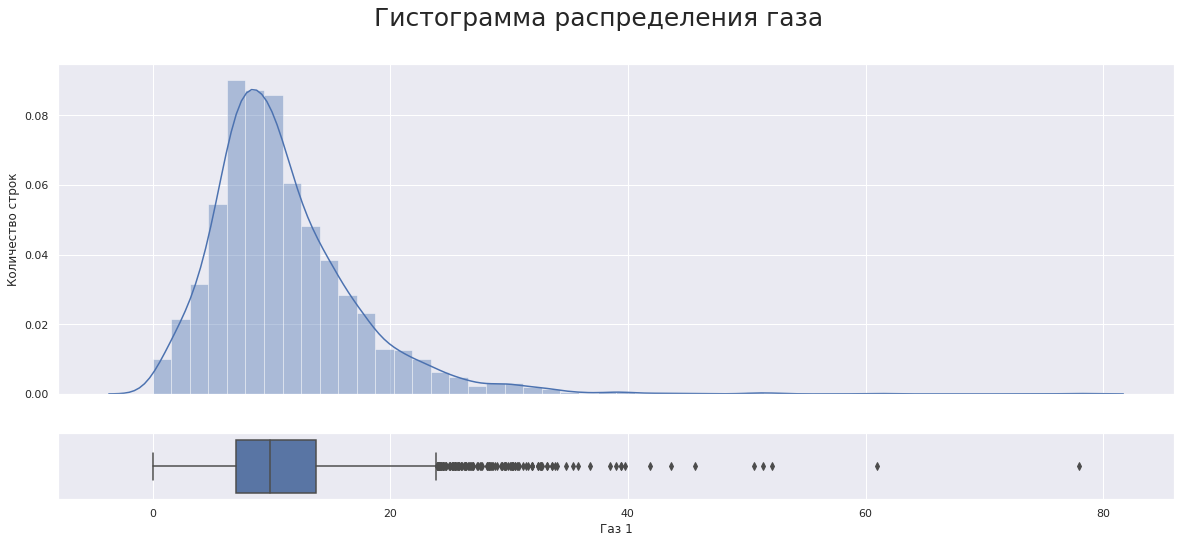

In [80]:
# гистограмма и боксплот 
f, [ax_hist, ax_box] = plt.subplots(2, 1, sharex=True, figsize=(20,8), 
                                                             gridspec_kw=dict(height_ratios=[10,2]))
sns.boxplot(data_gas['Газ 1'], ax=ax_box)
sns.distplot(data_gas['Газ 1'], ax=ax_hist)

 
ax_hist.set(xlabel='Газ', ylabel='Количество строк')
f.suptitle('Гистограмма распределения газа', fontsize=25);

In [81]:
data_gas[data_gas['Газ 1']>60]

,key,Газ 1
277,280,60.935689
319,322,77.995040


Распределение данных стремиться к нормальному с хвостом справа. Объем газа для продувки варьируется от 0,008 до 80 кубометром. Чаще всего продувают сплав примерно 10 кубометрами газа. Наблюдаются выбросы более 60 кубометров газа, неизвестно, чем это может быть обусловлено, пока оставим без изменений.

## Pезультаты измерения температуры

In [82]:
begin(data_temp)


    Состав таблицы: Pезультаты измерения температуры 



,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0



    Общая информация: Pезультаты измерения температуры 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
None

    Описательная статистика: Pезультаты измерения температуры 



,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000



Количество пропущенных значений 3427
Количество дубликатов: 0
Количество уникальных партий - 3216


В таблице результаты измерения температуры всего 18092 значения и 3 столбца. Количество уникальных партий - 3216. В столбце Температура наблюдаются примерно 19% пропущенных значений - это довольно много, но, так как это наш результирующий признах, удалим пропущенные значения. Также необходимо заменить тип данных в столбце Время замера.

In [83]:
# удаляем пропущенные значения
data_temp=data_temp.dropna()

In [84]:
# меняем тип данных
data_temp['Время замера'] = data_temp['Время замера'].astype('datetime64')

In [85]:
# проверка
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14665 entries, 0 to 18086
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           14665 non-null  int64         
 1   Время замера  14665 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 458.3 KB


In [86]:
# проверка после удаления пропущенных значений
data_temp.describe()

,key,Температура
count,14665.000000,14665.000000
mean,1325.484214,1590.722741
std,787.375969,20.394381
min,1.000000,1191.000000
25%,654.000000,1580.000000
50%,1314.000000,1590.000000
75%,1963.000000,1599.000000
max,3241.000000,1705.000000


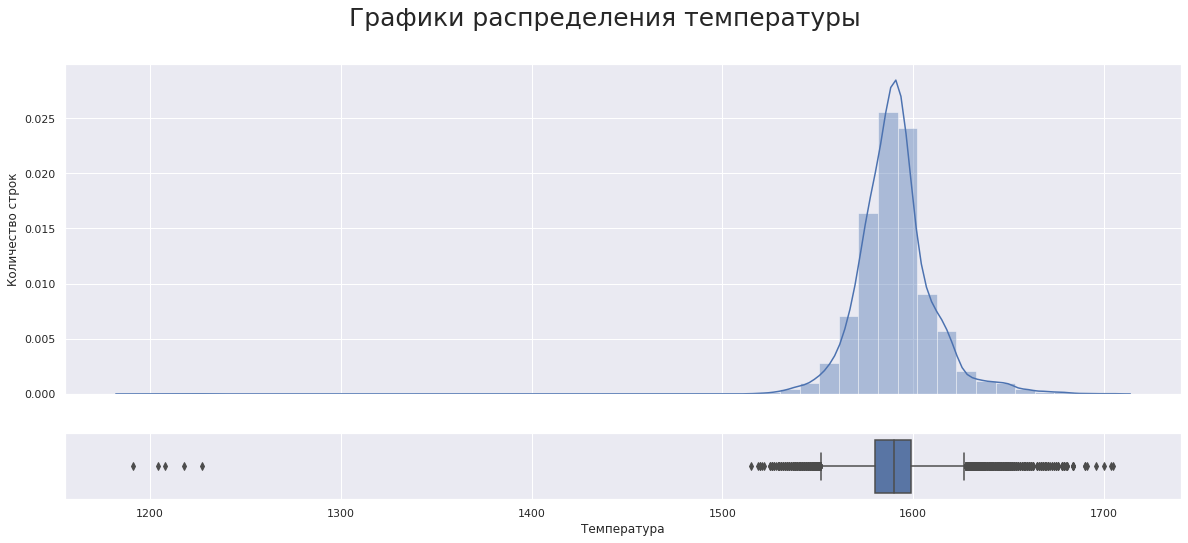

In [87]:
# Посмотрим распределение данных
f, [ax_hist, ax_box] = plt.subplots(2, 1, sharex=True, figsize=(20,8), 
                                                             gridspec_kw=dict(height_ratios=[10,2]))

sns.boxplot(data_temp['Температура'], ax=ax_box)
sns.distplot(data_temp['Температура'], ax=ax_hist)


ax_hist.set(xlabel='Газ', ylabel='Количество строк')
f.suptitle('Графики распределения температуры', fontsize=25);

Распределение похоже на нормальное. Присутствуют выбросы менее 1300 градусов, хотя среднее значение практически сходится с медианой и равна 1590 градусов. Погуглив, узнала, что сталь плавиться от 1350 градусов, но т.к. использовались добавки, возможно, это повлияло на низкую температуру плавления. Пока эти данные не удаляем, рассмотрим их  в итоговой таблице.

## Данные о проволочных материалах (объём)

In [88]:
begin(data_wire)


    Состав таблицы: Данные о проволочных материалах (объём) 



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



    Общая информация: Данные о проволочных материалах (объём) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None

    Описательная статистика: Данные о проволочных материалах (объём) 



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604



Количество пропущенных значений 23385
Количество дубликатов: 0
Количество уникальных партий - 3081


Как и в случае с сыпучими материалами, видно, что разные виды проволоки добавляются в разных объемах или не добавляются вообще. С этим связаны пропущенные значения.

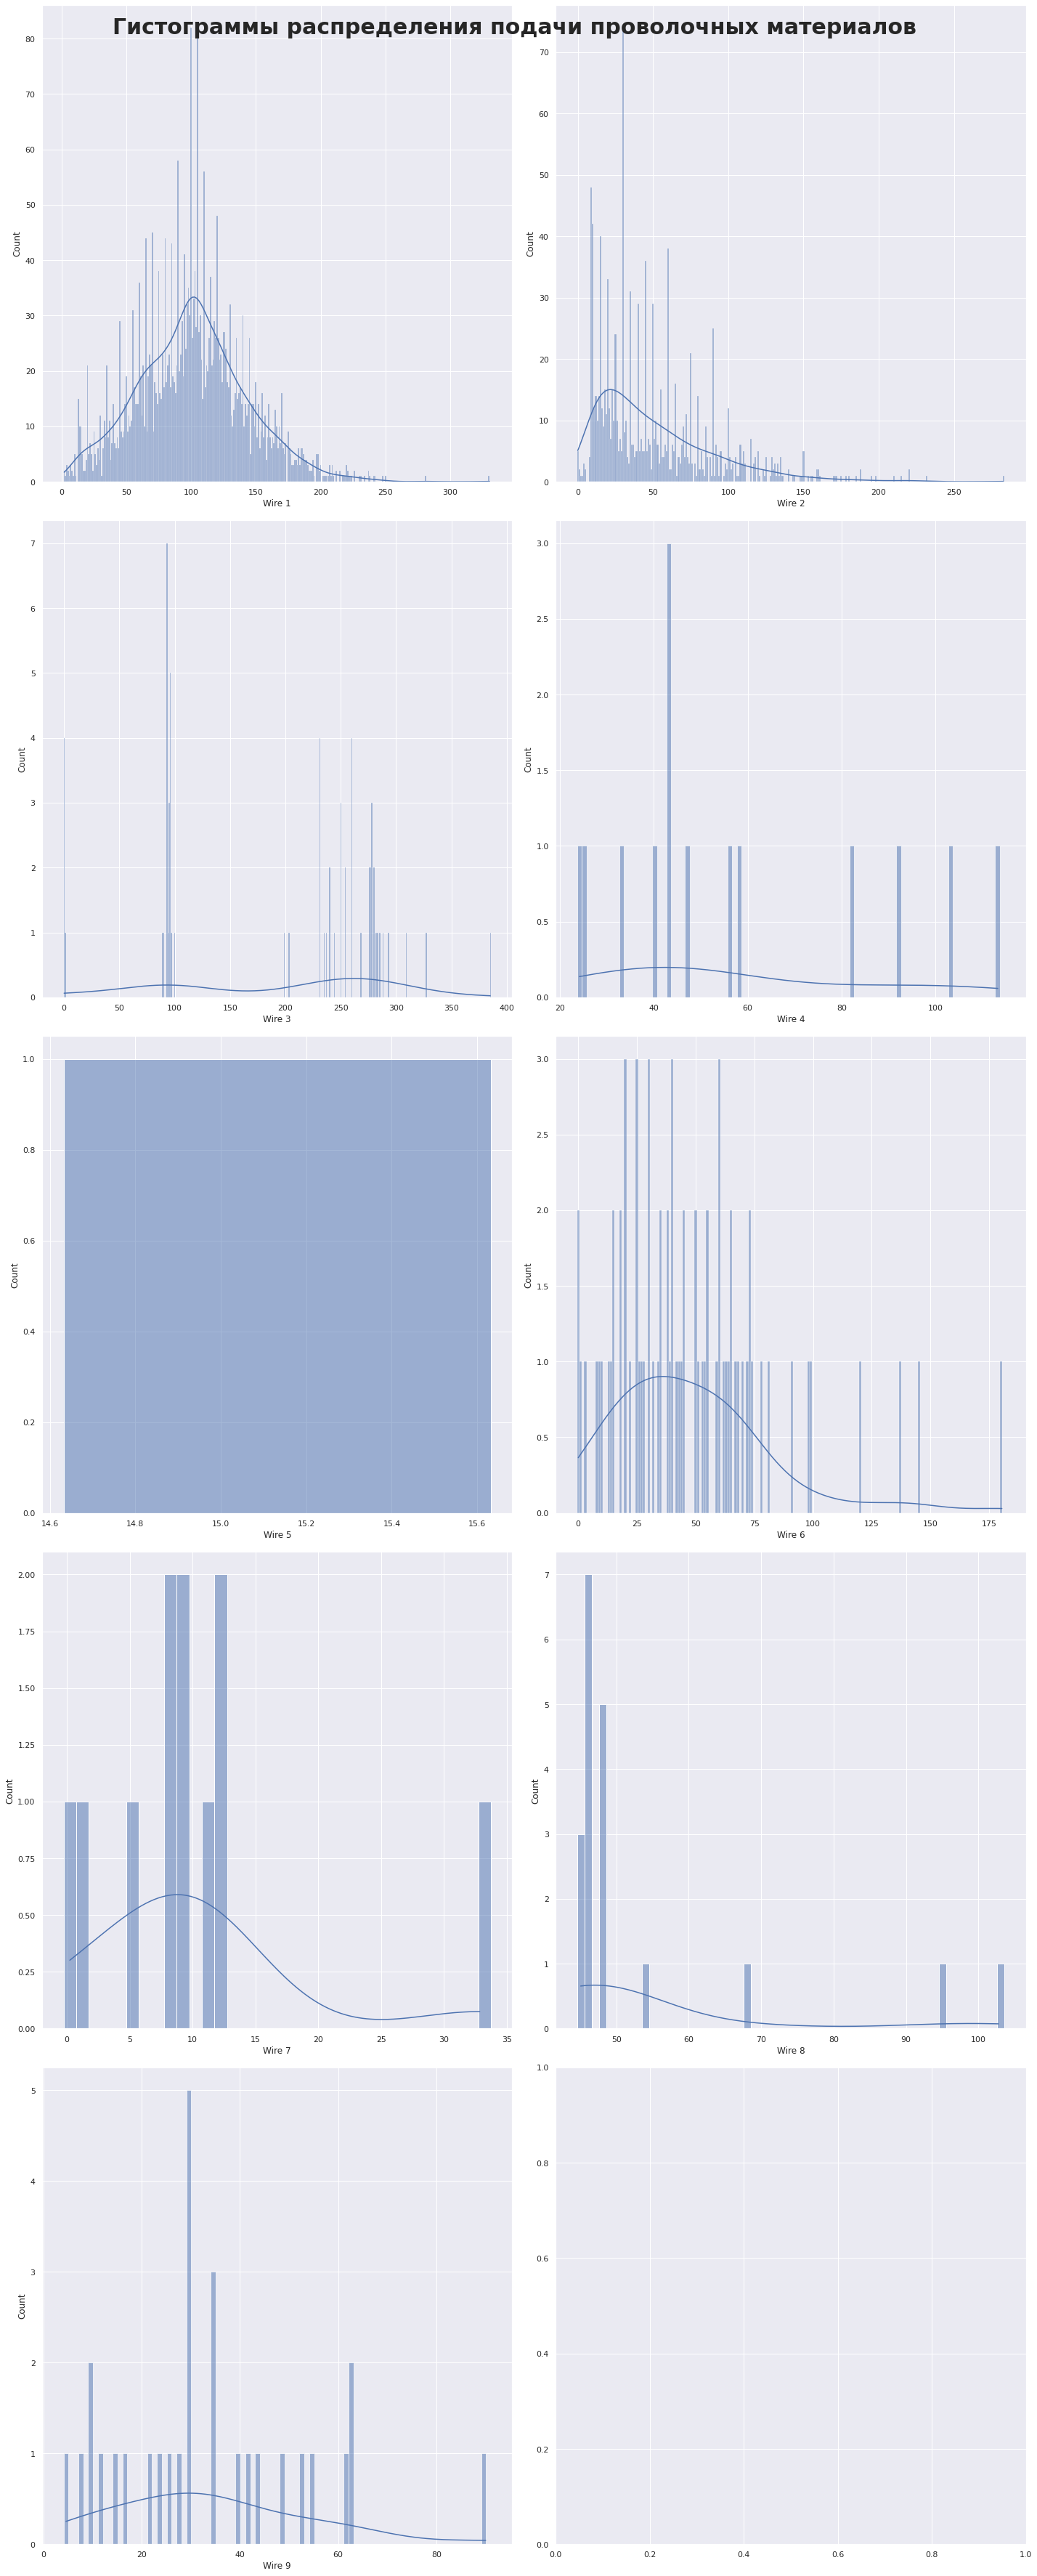

In [89]:
# построим гистограмму распределения
fig, ax = plt.subplots(5, 2, figsize = (20,50))
fig.suptitle('Гистограммы распределения подачи проволочных материалов ', fontsize = 30, fontweight='bold')
wires = data_wire.columns.to_list()[1:]
ax = ax.flatten()


for i, wire in enumerate(wires):
    wire_hist=sns.histplot(data=data_wire, x=wire, kde=True, ax=ax[i], discrete=True)
    bulk_hist.set_ylabel('Количество строк')
    bulk_hist.set_title('Гистограмма распределения подачи проволочных материалов. ' + bulk)
  
    plt.tight_layout()

Отметим, что чаще всего добавлялось Wire 1, всего один раз добавили Wire 5. Заменим пропущенные значения нулем, так как в этих партиях проволочные материалы не добавлялись.

In [90]:
# замена пропущенных значений
data_wire = data_wire.fillna(0)

In [91]:
# проверка
data_wire.isna().sum().sum()

0

## Данные о проволочных материалах (время)

In [92]:
begin(data_wire_time)


    Состав таблицы: Данные о проволочных материалах (время) 



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



    Общая информация: Данные о проволочных материалах (время) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None

    Описательная статистика: Данные о проволочных материалах (время) 



,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000



Количество пропущенных значений 23385
Количество дубликатов: 0
Количество уникальных партий - 3081


Изменим тип данных на корректный и построим гистограмму распределения

In [93]:
# замена типа данных
data_wire_time[wires] = data_wire_time[wires].astype('datetime64')

In [94]:
# проверка
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


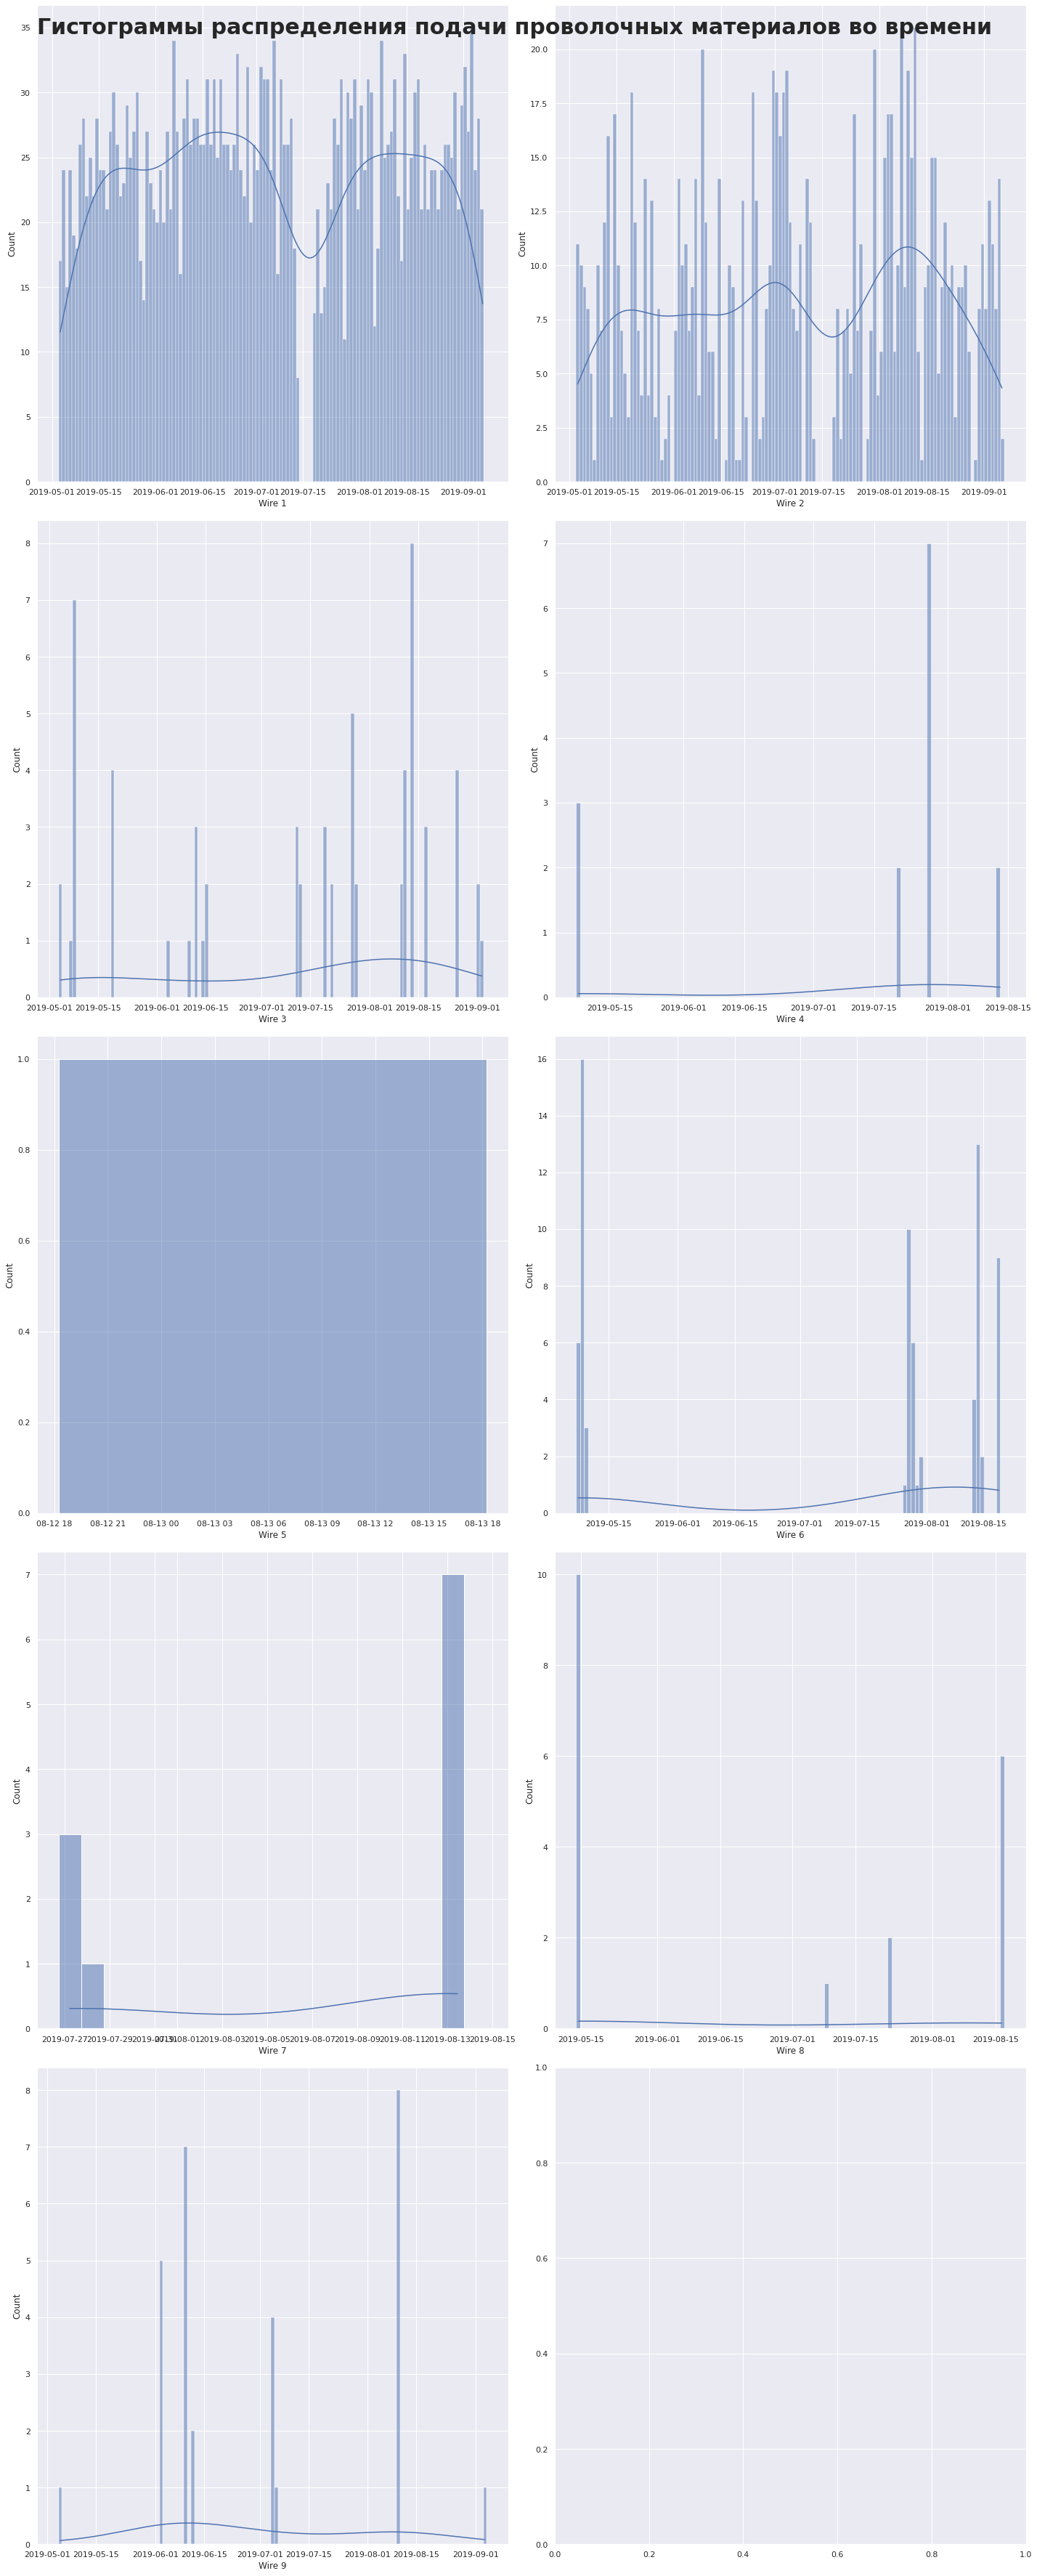

In [95]:
# построим гистограмму распределения
fig, ax = plt.subplots(5, 2, figsize = (20,50))
fig.suptitle('Гистограммы распределения подачи проволочных материалов во времени ', fontsize = 30, fontweight='bold')
wires = data_wire.columns.to_list()[1:]
ax = ax.flatten()


for i, wire in enumerate(wires):
    wire_hist=sns.histplot(data=data_wire_time, x=wire, kde=True, ax=ax[i], discrete=True)
    bulk_hist.set_ylabel('Количество строк')
    bulk_hist.set_title('Гистограмма распределения подачи проволочных материалов. ' + bulk)
  
    plt.tight_layout()

По гистограммам видно, что есть пропуски в июле аналогично пропускам в data_arc, data_bulk_time. В соответствие с датафреймом data_wire, на гистограммах видно, что разные проволоки добавляют с разной частотой.

## Вывод по исследовательскому анализу и начальной предобработке

Нам предоставлены данные с 3 мая 2019 года по 6 сентября 2019 года. В данных наблюдается отсутсвие информации 14-17 июля. Скорее всего это связано с аварией или простоем производства.
В датафрейме - data_arc был выброс - отрицательная реактивная мощность, этот выброс был удален. Также была обнаружена мультиколлениарность между Активной мощностью и Pеактивной. Во избежании некорректного предсказания модели была посчитана Полная мощность, которая в дальнейшем будет выступать одним из признаков в моделе.

В датафреймах data_bulk, data_wire есть пропуски данных. Причина части пропусков из-за того, что в определенных партиях не подавались добавки. Поэтому пропущенные значения были исправлены на 0, т.е. добавки не добавлялись.

В датафрейме data_temp - является нашим таргетом, поэтому пропущенные значения были удалены. Также наблюдаются выбросы температуры менее 1300 градусов, оставили их без изменения до обучения модели.

Обнаружились выбросы в датафрейме data_gas, где Газ больше 60 куб.метром. Тоже оставила без изменений до обучения модели.




## План проекта:
**1. Провести исследовательский анализ и начальную предобработку данных:**
- привести типы данных к корректному виду;
- рассмотреть и заменить/удалить пропущенные значения;
- рассмотреть аномальные значения (выбросы), при невозможности заменить их - удалить;
- проверить таблицы на дублирующие значения;
- рассмотреть распределение данных.

**2. Подготовка данных к предсказанию:**
- удалить промежуточные температуры из data_temp;
- добавить новые признаки - количество нагрева, время нагрева электродами, общее количество присадок для каждой партии для дальнейшего обучения модели.

**3. Объединение таблиц по ключам:**
- проанализировать данные после объединения;
- рассмотреть корреляцию между признаками в общей таблице.

**4. Разделение на тестовую и обучающую выборки:**
- проанализировать данные в обучающей выборке;
- рассмотреть и удалить выбросы в обучающей выборке (если нужно).

**5. Выбор оптимальных гиперпараметров, обучение моделей**

**6. Выбор наилучшей модели по показателю MAE**

**7. Предсказание на тестовой выборке**

**8. Анализ значимости признаков на тестовой выборке**

**9. Проверка на адекватность тестовой модели с константной моделью**




# 2. Подготовка данных к обучению

In [96]:
# исходный датафрейм для проверки
data_temp[data_temp['key']==1]

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0


In [97]:
# удаляем из таблицы значения, где указана только одна температура
data_temp = data_temp[data_temp['key'].duplicated(keep = False)]

In [98]:
# проверка после преобразований, первая температура сохранилась
data_temp[data_temp['key']==1]

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0


In [99]:
# проверка после удаления
data_temp['key'].value_counts()

2108    17
1513    16
1689    16
322     14
46      14
        ..
556      2
661      2
1568     2
2112     2
614      2
Name: key, Length: 2475, dtype: int64

In [100]:
# удаляем промежуточные значения температуры в датафрейме data_temp при помощи функции
def delete_row(data):
    data_finish=pd.DataFrame()
    for k in data['key'].unique():
        data_sort = ((data[data['key']==k]).sort_values(by='Время замера')).iloc[[0,-1]].reset_index(drop=True)
        data_finish = data_finish.append(data_sort)
      
    return data_finish
        

In [101]:
# применяем функцию
data_temp_new = delete_row(data_temp)
data_temp_new

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:30:38,1613.0
0,2,2019-05-03 11:34:04,1581.0
1,2,2019-05-03 11:55:09,1602.0
0,3,2019-05-03 12:06:44,1596.0
...,...,...,...
1,2497,2019-08-10 12:53:28,1589.0
0,2498,2019-08-10 12:58:11,1591.0
1,2498,2019-08-10 13:23:31,1594.0
0,2499,2019-08-10 13:33:21,1569.0


In [102]:
# проверка с таблицей с промежуточными итогами
data_temp[data_temp['key']==2]

,key,Время замера,Температура
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0
10,2,2019-05-03 11:55:09,1602.0


В таблице data_temp_new наш target - это последний замер температуры, поэтому строки начала и конца преобразуем в столбцы и добавим новый признак "Время между замерами"

In [103]:
# преобразуем значения температут в столбцы
data_temp_new = data_temp_new.pivot_table(index='key', values='Температура', aggfunc=['first', 'last']).reset_index()
data_temp_new.columns = data_temp_new.columns.droplevel()
data_temp_new.columns = ['key', 'Температура начальная','Температура конечная']

In [104]:
data_temp_new

,key,Температура начальная,Температура конечная
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2470,2495,1570.0,1591.0
2471,2496,1554.0,1591.0
2472,2497,1571.0,1589.0
2473,2498,1591.0,1594.0


Добавляем новые признаки для дальнейшего обучения модели 

In [105]:
# в таблицу data_arc добавим новый столбец "Время нагрева"
data_arc['Время нагрева, сек.'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.total_seconds()

In [106]:
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,"Время нагрева, сек."
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,148.0
...,...,...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,0.532085,157.0
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,0.792429,180.0
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,1.293389,184.0
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,0.641792,57.0


In [107]:
# создадим новый датафрейм с количеством нагревов/ временем нагрева и общей мощностью по каждой партии
data_arc_count = data_arc.pivot_table(index='key', values=['Полная мощность', 'Время нагрева, сек.'], aggfunc=['count', 'sum']).reset_index()
# удаляем дублирующий столбец
data_arc_count = data_arc_count.drop(('count', 'Время нагрева, сек.'), axis=1)
# переименовываем столбцы
data_arc_count.columns = list(map("_".join, data_arc_count.columns))
data_arc_count = data_arc_count.rename(columns={('count_Полная мощность'): 'Количество нагрева', ('sum_Время нагрева, сек.'): 'Суммарное время нагрева', ('sum_Полная мощность'): 'Суммарная мощность', 'key_': 'key'})
data_arc_count

,key,Количество нагрева,Суммарное время нагрева,Суммарная мощность
0,1,5,1098.0,3.718736
1,2,4,811.0,2.588349
2,3,5,655.0,5.019223
3,4,4,741.0,3.400038
4,5,4,869.0,2.816980
...,...,...,...,...
3209,3237,5,909.0,3.250657
3210,3238,3,546.0,1.723937
3211,3239,8,1216.0,6.014480
3212,3240,5,839.0,4.082920


При подготовке данных к обучению были удалены промежуточные температуры, температуры по партиям, которые встречальсь в таблице меньше 2 раз. В таблице data_temp_new выделен наш целевой признак в отдельном столбце. Добавлены новые признаки для дальнейшего обучения, такие как "Количество нагрева", "Суммарное время нагрева" и "Суммарная мощность"

## Объединение таблиц по ключам

Объединяем таблицы data_arc_count, data_gas, data_bulk, data_wire, data_temp_new. После объединения проведем анализ.

In [108]:
data = data_temp_new.merge(data_arc_count, on ='key', how='inner')\
                    .merge(data_gas, on ='key', how='inner')\
                    .merge(data_bulk, on ='key', how='inner')\
                    .merge(data_wire, on ='key', how='inner')

In [109]:
# через функцию загрузим информацию для анализа
data.name = 'Общая таблица'
begin(data)


    Состав таблицы: Общая таблица 



,key,Температура начальная,Температура конечная,Количество нагрева,Суммарное время нагрева,Суммарная мощность,Газ 1,Bulk 1,Bulk 2,Bulk 3,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,1571.0,1613.0,5,1098.0,3.718736,29.749986,0.0,0.0,0.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,4,811.0,2.588349,12.555561,0.0,0.0,0.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,5,655.0,5.019223,28.554793,0.0,0.0,0.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,4,741.0,3.400038,18.841219,0.0,0.0,0.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,4,869.0,2.816980,5.413692,0.0,0.0,0.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,1543.0,1596.0,4,952.0,3.313074,11.273392,0.0,0.0,0.0,...,154.0,99.109917,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,1586.0,1599.0,4,673.0,3.283913,9.836267,0.0,0.0,0.0,...,154.0,98.061600,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0



    Общая информация: Общая таблица 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   key                      2329 non-null   int64  
 1   Температура начальная    2329 non-null   float64
 2   Температура конечная     2329 non-null   float64
 3   Количество нагрева       2329 non-null   int64  
 4   Суммарное время нагрева  2329 non-null   float64
 5   Суммарная мощность       2329 non-null   float64
 6   Газ 1                    2329 non-null   float64
 7   Bulk 1                   2329 non-null   float64
 8   Bulk 2                   2329 non-null   float64
 9   Bulk 3                   2329 non-null   float64
 10  Bulk 4                   2329 non-null   float64
 11  Bulk 5                   2329 non-null   float64
 12  Bulk 6                   2329 non-null   float64
 13  Bulk 7                   2329 non-null 

,key,Температура начальная,Температура конечная,Количество нагрева,Суммарное время нагрева,Суммарная мощность,Газ 1,Bulk 1,Bulk 2,Bulk 3,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,...,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.0,2329.000000,2329.000000,2329.000000,2329.000000
mean,1251.832546,1586.718763,1593.365393,4.695148,807.600687,3.884654,11.375600,3.427651,1.422499,47.348218,...,119.952769,102.443601,17.609859,3.234916,0.306550,0.0,0.978820,0.006361,0.311311,0.317113
std,714.762400,28.290792,11.200915,1.606948,340.897332,1.518157,6.392041,12.412132,19.082119,75.310430,...,84.640443,43.539993,33.624771,27.942871,4.757746,0.0,8.693299,0.205705,4.402707,3.456561
min,1.000000,1191.000000,1541.000000,1.000000,57.000000,0.331897,0.008399,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,630.000000,1571.000000,1587.000000,4.000000,581.000000,2.843058,7.282948,0.000000,0.000000,0.000000,...,0.000000,73.207679,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,1255.000000,1587.000000,1593.000000,5.000000,778.000000,3.767499,10.100950,0.000000,0.000000,0.000000,...,107.000000,101.119201,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,1868.000000,1603.000000,1598.000000,6.000000,993.000000,4.769421,14.216688,0.000000,0.000000,80.000000,...,204.000000,128.091599,23.102560,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
max,2499.000000,1660.000000,1653.000000,16.000000,4189.000000,15.288271,77.995040,185.000000,325.000000,454.000000,...,405.000000,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600



Количество пропущенных значений 0
Количество дубликатов: 0
Количество уникальных партий - 2329


После объединения в конечной таблице всего 2329 значений. Удалим столбец Wire 5, т.к. в нем нет значений.

In [110]:
# удаляем столбец Wire 5
data.drop(['Wire 5'],inplace=True, axis=1)

In [111]:
# проверка
data.shape

(2329, 30)

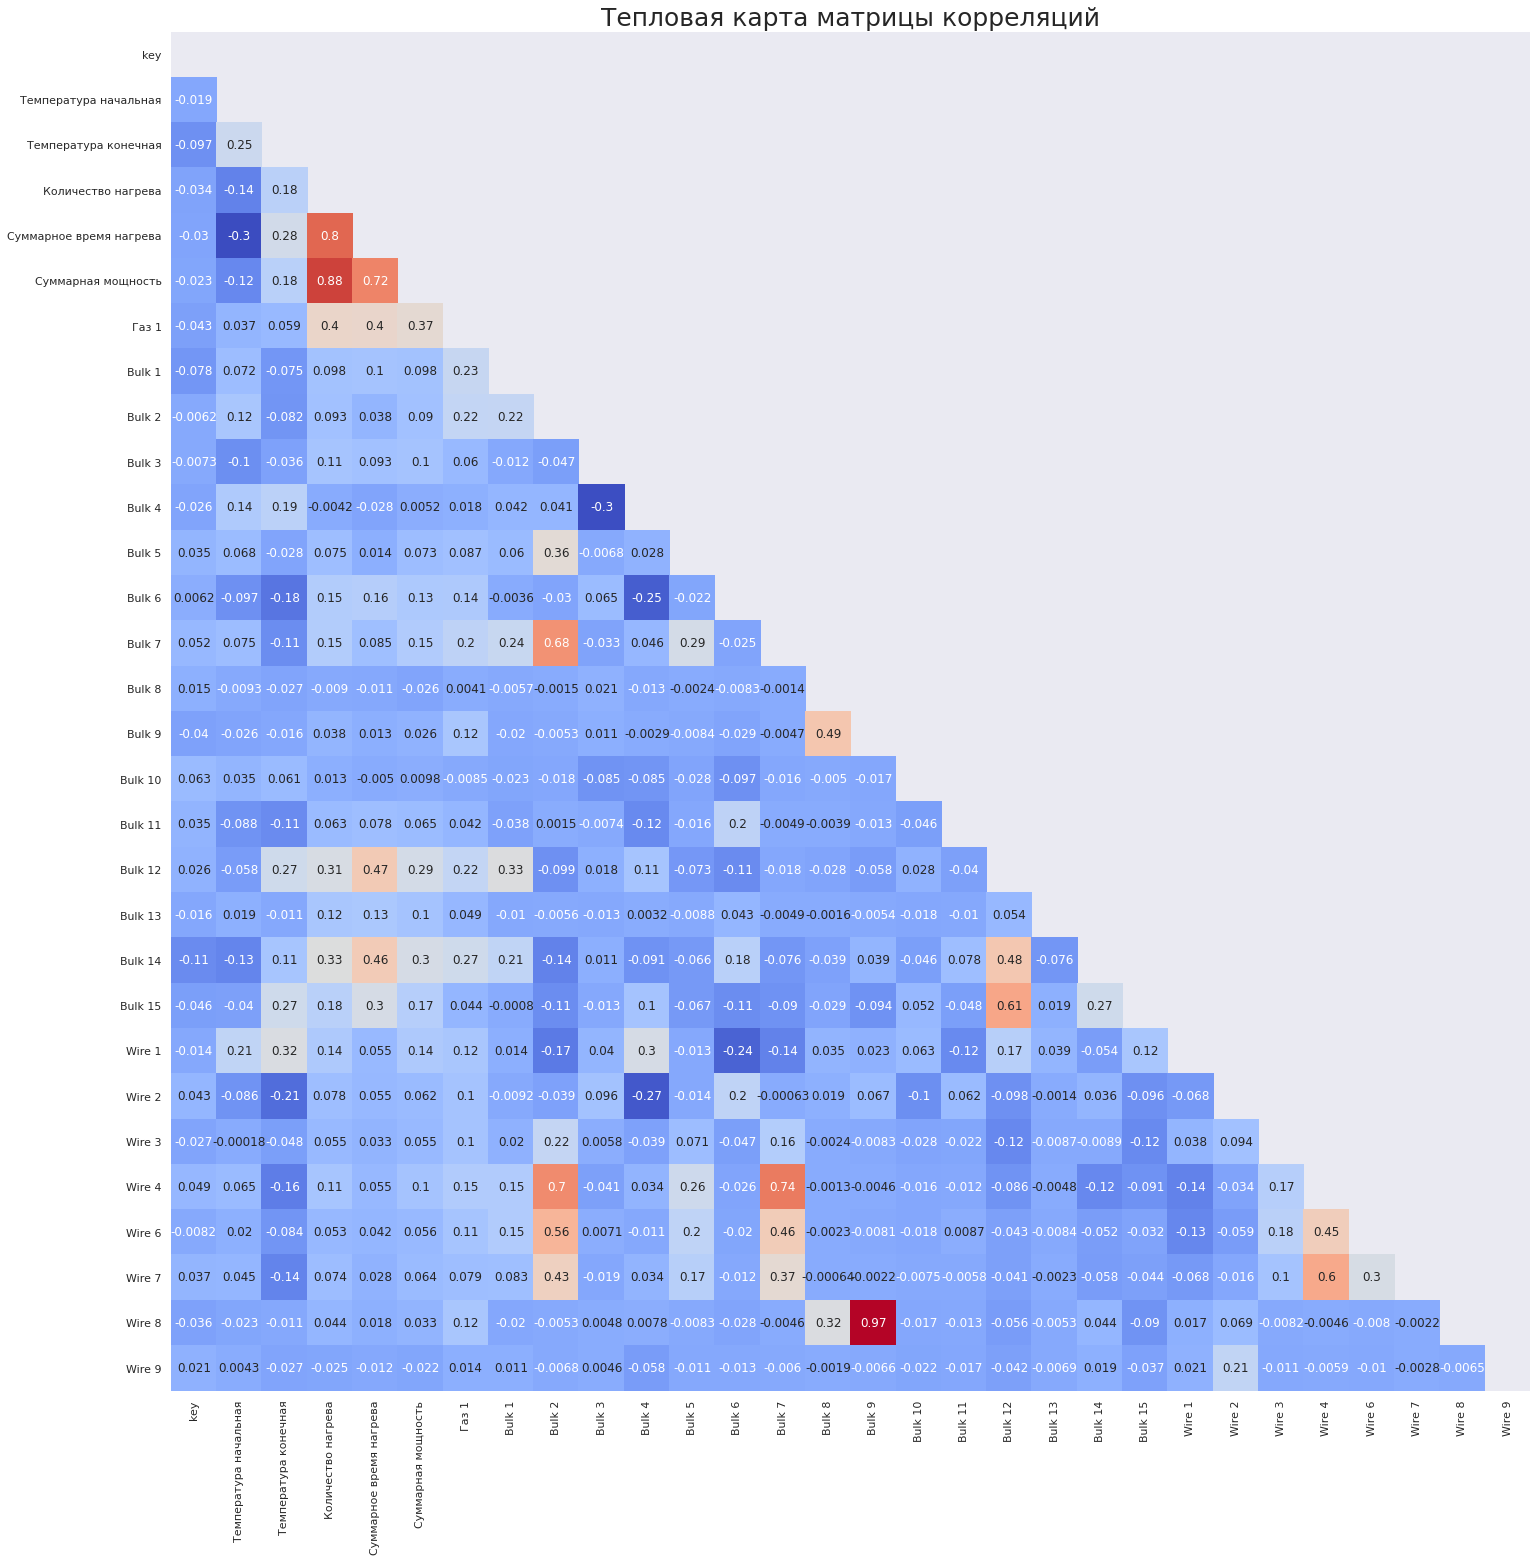

In [112]:
# посмотрим корреляцию между признаками
plt.figure(figsize=(25, 25))
matrix = np.triu(data.corr())
heatmap = sns.heatmap(data.corr(),
                      annot=True,
                      mask=matrix,
                      square=True,
                      cmap='coolwarm',
                      cbar=False,
                      fmt='.2g')
heatmap.set_title('Тепловая карта матрицы корреляций', fontsize=25);

Отметим полную  положительную связь между (Wire 9 и Bulk 9), скорее всего, это связано с тем, что чем больше добавляют одну из этих присадок тем больше добавляется другая. Сильная связь между "Сумарным временем нагрева" и "Количеством нагрева", Wire 4 и Bulk 2, Wire 4 и Bulk 7.

Наш целевой признак сильнее всего положительно коррелирует с "Суммарное время нагрева", Bulk 12, Bulk 15, Wire 1. Отрицательная кореляция наблюдается с признаком Wire 2 и Bulk 6.


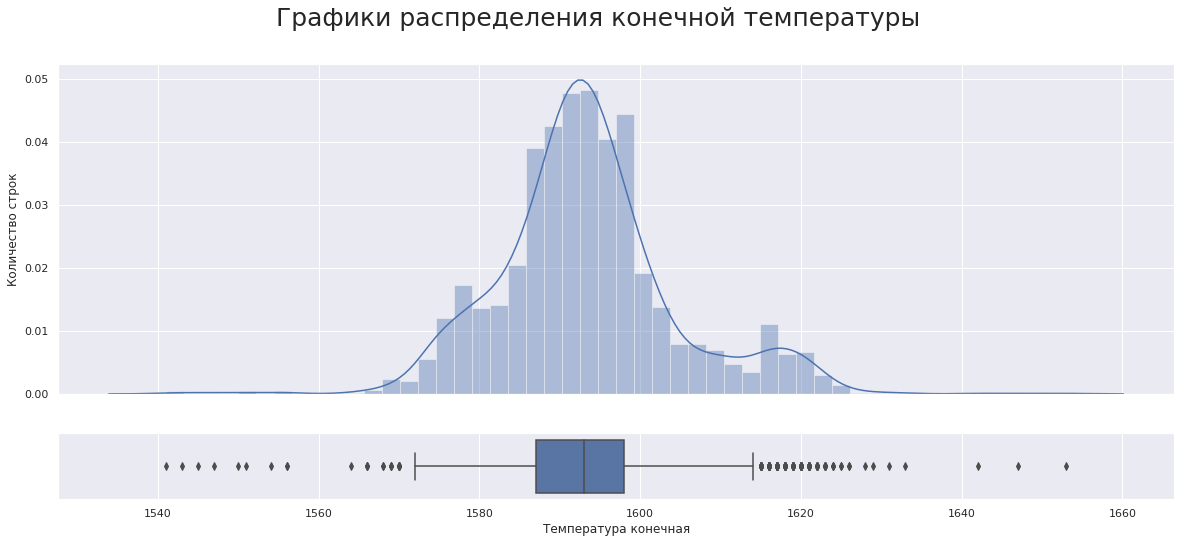

In [113]:
# Посмотрим распределение конечной температуры
f, [ax_hist, ax_box] = plt.subplots(2, 1, sharex=True, figsize=(20,8), 
                                                             gridspec_kw=dict(height_ratios=[10,2]))

sns.boxplot(data['Температура конечная'], ax=ax_box)
sns.distplot(data['Температура конечная'], ax=ax_hist)


ax_hist.set(xlabel='Газ', ylabel='Количество строк')
f.suptitle('Графики распределения конечной температуры', fontsize=25);

Отметим, что при соединении таблиц, температура меньше 1500 градусов исчезла.

После объединения таблиц наша общая таблица состоит из 2329 строк и 29 столбцов. Признак Wire 5 оказался пустой и был удален. Рассмотрена взаимосвязь между признаками.

## 4. Разделение на тестовую и обучающую выборки

In [114]:
RANDOM_STATE = 150523

In [115]:
target = data['Температура конечная']
features = data.drop(['Температура конечная', 'key'], axis=1)

In [116]:
# проверка
print(target.shape)
print(features.shape)

(2329,)
(2329, 28)


In [117]:
# деление на тестовую и обучающую выборку
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.25, random_state = RANDOM_STATE)

In [118]:
# проверка
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(1746, 28)
(583, 28)
(1746,)
(583,)


## 5. Выбор оптимальных гиперпараметров, обучение моделей

При помощи GreedSearchCV подберем оптимальные гиперпараметры. Мы будем изучать модели СatBoostRegressor, LGBRegressor, RandomForestRegressor

In [119]:
# посчитаем фолды
folds = KFold(n_splits=5,  shuffle=True, random_state=RANDOM_STATE)

### CatBoostRegressor

In [70]:
%%time
model_cb = CatBoostRegressor(random_state=RANDOM_STATE)
param_cb = {'learning_rate':[0.01, 0.1, 0.25],
              'n_estimators' : [x for x in range(50,260,50)],
              'max_depth' : [5, 10, 12],
               'random_state' : [RANDOM_STATE],
               'verbose' : [20]}
grid_cb = GridSearchCV(estimator=model_cb,
                       param_grid=param_cb,
                       n_jobs=-1,
                       scoring='neg_mean_absolute_error',
                        cv=folds)
grid_cb.fit(features_train, target_train)
mae_cb = round(abs(grid_cb.best_score_),4)
print(grid_cb.best_params_)
print('MAE модели CatBoost на кросс-валидации:', mae_cb)

0:	learn: 10.9385955	total: 140ms	remaining: 27.9s
20:	learn: 8.7122075	total: 164ms	remaining: 1.4s
40:	learn: 8.0884287	total: 187ms	remaining: 725ms
60:	learn: 7.7357391	total: 210ms	remaining: 478ms
80:	learn: 7.4647127	total: 233ms	remaining: 342ms
100:	learn: 7.1674845	total: 256ms	remaining: 251ms
120:	learn: 6.8757198	total: 278ms	remaining: 182ms
140:	learn: 6.6754493	total: 301ms	remaining: 126ms
160:	learn: 6.4752336	total: 325ms	remaining: 78.7ms
180:	learn: 6.2990090	total: 350ms	remaining: 36.7ms
199:	learn: 6.1086122	total: 371ms	remaining: 0us
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'random_state': 150523, 'verbose': 20}
MAE модели CatBoost на кросс-валидации: 6.2781
CPU times: total: 2.94 s
Wall time: 11min 19s


### LGBMRegressor

In [71]:
%%time
model_lgb = LGBMRegressor(random_state=RANDOM_STATE)
param_lgb = {'learning_rate':[0.01, 0.1, 0.25],
              'num_leaves':[x for x in range(10,26)],
              'random_state' : [RANDOM_STATE]}
grid_lgb = GridSearchCV(estimator=model_lgb,
                       param_grid=param_lgb,
                       n_jobs=-1,
                       scoring='neg_mean_absolute_error', 
                       cv=folds)
grid_lgb.fit(features_train, target_train)
mae_lgb = round(abs(grid_lgb.best_score_),4)
print(grid_lgb.best_params_)
print('MAE модели LGBMRegressor на кросс-валидации:', mae_lgb)

{'learning_rate': 0.1, 'num_leaves': 10, 'random_state': 150523}
MAE модели LGBMRegressor на кросс-валидации: 6.4457
CPU times: total: 781 ms
Wall time: 3.25 s


### RandomForestRegressor

In [72]:
%%time
model_rf = RandomForestRegressor(random_state=RANDOM_STATE)
param_rf = {'criterion':['mae'],
            'n_estimators' : [x for x in range(50,260,50)],
              'max_depth':[x for x in range(1,26,5)],
              'random_state' : [RANDOM_STATE]}
grid_rf = GridSearchCV(estimator=model_rf,
                       param_grid=param_rf,
                       n_jobs=-1,
                       scoring='neg_mean_absolute_error', 
                       cv=folds)
grid_rf.fit(features_train, target_train)
mae_rf = round(abs(grid_rf.best_score_),4)
print(grid_rf.best_params_)
print('MAE модели LGBMRegressor на кросс-валидации:', mae_rf)

{'criterion': 'mae', 'max_depth': 11, 'n_estimators': 200, 'random_state': 150523}
MAE модели LGBMRegressor на кросс-валидации: 6.463
CPU times: total: 22.7 s
Wall time: 3min 14s


In [73]:
cv_tabl = pd.DataFrame(index=['MAE на кросс-валидации','Оптимальные гиперпараметры'], columns=['CatBoostRegressor','LGBMRegressor', 'RandomForestRegressor'])
column = ['MAE на кросс-валидации','Оптимальные гиперпараметры']
cv_tabl['CatBoostRegressor'] = mae_cb, grid_cb.best_params_
cv_tabl['LGBMRegressor'] = mae_lgb, grid_lgb.best_params_
cv_tabl['RandomForestRegressor'] = mae_rf, grid_rf.best_params_


cv_tabl.T.style 

,MAE на кросс-валидации,Оптимальные гиперпараметры
CatBoostRegressor,6.278100,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'random_state': 150523, 'verbose': 20}"
LGBMRegressor,6.445700,"{'learning_rate': 0.1, 'num_leaves': 10, 'random_state': 150523}"
RandomForestRegressor,6.463000,"{'criterion': 'mae', 'max_depth': 11, 'n_estimators': 200, 'random_state': 150523}"


Таким образом, наилучшее качество модели на этапе обучения показала модель CatBoostRegressor, с наилучшими параметрами max_depth = 5, n_estimators = 200, random_state = 150523. Наихудшее качество показала модель LGBMRegressor. Тестирование будем проводить на моделе CatBoostRegressor.

## 7. Предсказание на тестовой выборке

In [120]:
model_test = CatBoostRegressor(random_state=RANDOM_STATE, learning_rate=0.1, max_depth=5, n_estimators=200, verbose=20)
model_test.fit(features_train, target_train)
predict = model_test.predict(features_test)
print('MAE на тестовой выборке - ', round(abs(mean_absolute_error(predict, target_test)),4))


0:	learn: 10.9385955	total: 49.2ms	remaining: 9.79s
20:	learn: 8.7122075	total: 114ms	remaining: 974ms
40:	learn: 8.0884287	total: 173ms	remaining: 669ms
60:	learn: 7.7357391	total: 209ms	remaining: 477ms
80:	learn: 7.4647127	total: 259ms	remaining: 381ms
100:	learn: 7.1674845	total: 315ms	remaining: 308ms
120:	learn: 6.8757198	total: 374ms	remaining: 244ms
140:	learn: 6.6754493	total: 434ms	remaining: 182ms
160:	learn: 6.4752336	total: 484ms	remaining: 117ms
180:	learn: 6.2990090	total: 520ms	remaining: 54.6ms
199:	learn: 6.1086122	total: 556ms	remaining: 0us
MAE на тестовой выборке -  5.7575


На тестовой выборке MAE равно 5.75, что является меньше, чем по условию задачи.

## 8. Анализ значимости признаков на тестовой выборке

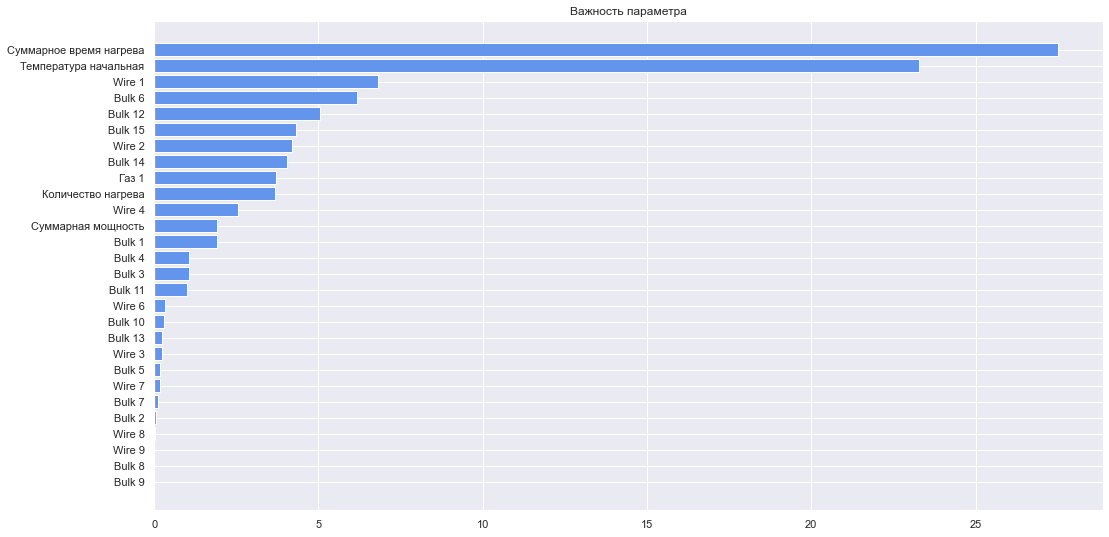

In [75]:
# рассчитаем важность параметров
importances_cat_new = model_test.feature_importances_
feat=features.columns
indices = np.argsort(importances_cat_new)
plt.figure(figsize=(17, 9))
plt.title('Важность параметра')
plt.barh(range(len(indices)), importances_cat_new[indices], color='#6495ED', align='center')
plt.yticks(range(len(indices)), feat[indices])
plt.show()

Большую значимость для модели имеют параметры Начальной температуры и Суммарное время нагрева, чуть в меньшей степени - Wire 1, Bulk 6, Bulk 14, Bulk 12. Наименьшую значимость имеют Bulk 8, Bulk 9, Wire 8, Wire 9, эти парметры вообще можно не включать в модель. 

## 9. Проверка на адекватность тестовой модели с константной моделью

Чтобы убедиться, что наша модель выполняет свою работу и имеет предсказательную силу, проверим адекватность модели

In [76]:
dummy = DummyRegressor(strategy='median')
dummy.fit(features_train, target_train)   
predict = dummy.predict(features_test)   
MAE_dummy = mean_absolute_error(target_test, predict)   
print('MAE константной модели -', round(MAE_dummy,4))

MAE константной модели - 8.0257


Таким образом, наша модель ведет себя лучше, это значит, что она имеет предсказательную силу. Можно сделать вывод, что модель подобрана правильно.

## Общий вывод

Для оптимизации расходов металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Была построить модель, которая предскажет температуру сплава.

Для решения данной задачи был проведен исследовательский анализ данных. На этапе анализа был выявлен простой в июле, обнаружены выбросы и пропущеные значения.
На этапе подготоки данных к обучению выбросы были удалены, пропущенные значения в добавках частично были заполнены нулями, т.е. добавки не подавались. Между признаки Реактивная и активная мощность обнаружилась очень сильная корреляция(почти 1), поэтому эти признаки были заменены на Полную корреляцию.

В таблице data_temp промежуточные значения были удалены, так как по условию задачи целевой признак - последняя температура. Также были удалены строки, где в партии был всего один замер температуры. Были выведены в отдельные столбцы начальная и конечная температуры.

Были посчитаны дополнительные признаки - Суммарное время нагрева, Количество нагревов и Суммарная мощность.

Полученные таблицы были объединены в общую таблицу по столбцу key. В итоге, таблица для обучения состоит из 29 столбцов и 2329 строк.
Также была изучена корреляция признаков, в результате были выявлены сильная корреляция между двумя признаками (легириующими добавками), но не выявлено сильной зависимости каких-либо признаков с целевым - конечной температурой.

Общая таблица была разделена на обучающую и тестовую выборки в соотношении 3:1. Для обучения моделей и предсказания были выбраны:
 - CatBoostRegressor;
 - LGBMRegressor;
 - RandomForestRegressor
 с кросс-валидацией и подбором оптимальные гиперпараметров при помощи GridSearchCV.
 
При обучении наилучшей моделью стала CatBoostRegressor с MAE=6.27 и наилучшими параметрами max_depth = 5, n_estimators = 200, random_state = 150523.
На тестовой выборке MAE=5.75, что удовлетворяет условию задачи. Также были выявлены значимые для модели признаки:
- наиболее значимые: Начальная температура, Суммарное время нагрева, Wire 1, Bulk 6, Bulk 14, Bulk 12.
- наименее значимые: Bulk 8. Bulk 9, Wire 8, Wire 9.

Проверку на адекватность модель прошла.

Таким образом, для предсказания конечной температуры сплава подойдет модель CatBoostRegressor, которая дает ошибку в 5.75 градуса.
 